In [6]:
import os
import scipy.io as sio
import sys 
import h5py as hp
import argparse
import random
from random import choices, choice
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors
from IPython.display import HTML, display, Image
from numpy.fft import ifft2,fft2,fft,ifft,fftfreq, fftshift
from scipy.signal import convolve2d, correlate2d
from IPython.display import HTML, display, Image
import time
from tqdm.auto import tqdm
from scipy.io import loadmat
from scipy.interpolate import interp1d

import torch
import math
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils import data
from tifffile import imread
from torchsummary import summary
from torch.nn.utils import spectral_norm
import itertools


def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

def rebin1d(arr, new_shape):
    shape = (new_shape, arr.shape[0] // new_shape)
    return arr.reshape(shape).mean(-1)

def normalize(x):
    return (x-np.amin(x))/(np.amax(x)-np.amin(x))

def centralpadding(arr, new_shape):
    if new_shape[0]>=arr.shape[0]:
        newarr = np.zeros(new_shape,dtype=complex)
        newarr[(new_shape[0] - arr.shape[0]) //2 : (new_shape[0] + arr.shape[0]) //2 ,
               (new_shape[1] - arr.shape[1]) //2 : (new_shape[1] + arr.shape[1]) //2 ] = arr
    else:
        newarr= arr[(-new_shape[0] + arr.shape[0]) //2 : (new_shape[0] + arr.shape[0]) //2 ,
               (-new_shape[1] + arr.shape[1]) //2 : (new_shape[1] + arr.shape[1]) //2 ]
    return newarr

def radial_profile(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)
    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile

def moving_average_smooth(data,window_width):
    cumsum_vec = np.cumsum(np.insert(data, 0, 0)) 
    ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
    return ma_vec
def autocor2d(I):
    f = fft2(I)
    f = np.absolute(f)**2
    autocor2d = ifftshift(ifft2(f))/I.shape[0]/I.shape[1]
    return autocor2d

def axis1norm(X):
    Y=np.zeros((X.shape[0],X.shape[1]))
    for i in range(X.shape[0]):
        Y[i,:] = X[i,:]/np.mean(X[i,:]**1)
    return Y

def axis0norm(X):
    Y=np.zeros((X.shape[0],X.shape[1]))
    for i in range(X.shape[1]):
        Y[:,i] = X[:,i]/np.mean(X[:,i]) 
    return Y

def ReLU(x):
    return x * (x > 0)


name = [#one interval
        '0-106 μm',
        '106-180 μm',
        '180-250 μm',
        '250-300 μm',
        '300-355 μm',
        '355-425 μm',
        '425-500 μm',
        '500-1000 μm',
        #two interval
        '106-250 μm',
        '180-300 μm',
        '250-355 μm',
        '300-425 μm',
        '355-500 μm',
        #three interval
        '180-355 μm',
        '250-425 μm',
        '300-500 μm',
        '355-1000 μm',
        #four interval
        '180-425 μm',
        '250-500 μm',
        #five interval
        '180-500 μm']



In [7]:
data_exp = np.load('../expdata/ASI1830MM_data/20curves_PSD_cumul_auto_sa.npz')
PSD_exp = data_exp["PSD_exp"] # PSD of the measured data
cumul_exp = data_exp['cumul_exp'] #cumul of the measured data
auto_exp = np.abs(data_exp['auto_sa'].reshape((20,20,1,64,64)))**0.25 #measured 200 frames average-autocorrelation
#take the 0.25 power to enhance the feature

data_sim = np.load('../expdata/ASI1830MM_data/simulation_PSD_cumul_auto.npz')
PSD_sim = data_sim["PSD_sim"] # PSD of the synthetic data
cumul_sim = data_sim['cumul_sim'] #cumul of the synthetic data
auto_sim = np.abs(data_sim['auto_sim'].reshape((2000,1,64,64)))**0.25 #calculation from the synthetic data 
auto_expgen = np.abs(data_sim['auto_expgen'].reshape((20,20,1,64,64)))**0.25 #calculation from the measured PSD

print(auto_exp.shape)
print(auto_sim.shape)
print(auto_expgen.shape)

(20, 20, 1, 64, 64)
(2000, 1, 64, 64)
(20, 20, 1, 64, 64)


In [8]:
#even index sets go to the training set (only train G)
#odd index sets go to the test set

auto_exp_train = np.zeros((10,20,1,64,64))
auto_expgen_train = np.zeros((10,20,1,64,64))
cumul_exp_train = np.zeros((10,20,192))

auto_exp_test = np.zeros((10,20,1,64,64))
auto_expgen_test = np.zeros((10,20,1,64,64))
cumul_exp_test = np.zeros((10,20,192))

for i in range(10):
    auto_exp_train[i] = auto_exp[2*i]
    auto_exp_test[i] = auto_exp[2*i+1]
    
    auto_expgen_train[i] = auto_expgen[2*i]
    auto_expgen_test[i] = auto_expgen[2*i+1]
    
    cumul_exp_train[i] = cumul_exp[2*i]
    cumul_exp_test[i] = cumul_exp[2*i+1]

In [9]:
split_point= 1600
batch_size = 4

############ set sim data ############

###train data
traindata_sim_a = torch.tensor(auto_sim[0:split_point], dtype=torch.float)
traindata_sim_c = torch.tensor(cumul_sim[0:split_point], dtype=torch.float)
#build dataset
trainset_sim = data.TensorDataset(traindata_sim_a,traindata_sim_c)
#load data
train_sim = torch.utils.data.DataLoader(trainset_sim, batch_size = batch_size, shuffle = True)


###test data
valdata_sim_a = torch.tensor(auto_sim[split_point:2000], dtype=torch.float)
valdata_sim_c = torch.tensor(cumul_sim[split_point:2000], dtype=torch.float)
#build dataset
valset_sim = data.TensorDataset(valdata_sim_a, valdata_sim_c)
#load data
val_sim = torch.utils.data.DataLoader(valset_sim, batch_size = batch_size, shuffle = True)

############ set exp data ############

###train data
traindata_exp_a = torch.tensor(np.concatenate(auto_exp_train,axis=0), dtype=torch.float)
traindata_exp_agen = torch.tensor(np.concatenate(auto_expgen_train,axis=0), dtype=torch.float)
traindata_exp_c = torch.tensor(np.concatenate(cumul_exp_train,axis=0), dtype=torch.float)
#build dataset
trainset_exp = data.TensorDataset(traindata_exp_agen,traindata_exp_a,traindata_exp_c)#, traindata_exp_c)
#load data
train_exp = torch.utils.data.DataLoader(trainset_exp, batch_size = batch_size, shuffle = True)



###test data
valdata_exp_agen = torch.tensor(np.concatenate(auto_expgen_test,axis=0), dtype=torch.float)
valdata_exp_a = torch.tensor(np.concatenate(auto_exp_test,axis=0), dtype=torch.float)
valdata_exp_c = torch.tensor(np.concatenate(cumul_exp_test,axis=0), dtype=torch.float)
#build dataset
valset_exp = data.TensorDataset(valdata_exp_agen, valdata_exp_a,valdata_exp_c)
#load data
val_exp = torch.utils.data.DataLoader(valset_exp, batch_size = batch_size, shuffle = True)


In [11]:
model_path = '7_supervise/7_supervise_generator_epoch_99.pt'
generator = torch.load(model_path)
generator.cuda()
model_path = '7_supervise/7_supervise_predictor_epoch_99.pt'
predictor = torch.load(model_path)
predictor.cuda()



Predictor(
  (down_residual_layer_1): down_residual_layer(
    (residual_block_1): residual_block(
      (a): LeakyReLU(negative_slope=0.01)
      (bn1): InstanceNorm2d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (bn2): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3): Conv2d(1, 8, kernel_size=(1, 1), stride=(2, 2))
    )
    (residual_block_2): residual_block(
      (a): LeakyReLU(negative_slope=0.01)
      (bn1): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (bn2): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    

In [53]:

def g_loss_npcc2d(generated_image, true_image):
    fsp=generated_image-torch.mean(generated_image,dim=(0,1,2,3),keepdim=True)
    fst=true_image-torch.mean(true_image,dim=(0,1,2,3),keepdim=True)
    
    devP=torch.std(generated_image,dim=(0,1,2,3))
    devT=torch.std(true_image,dim=(0,1,2,3))
    
    npcc_loss=(-1)*torch.mean(fsp*fst,dim=(0,1,2,3))/torch.clamp(devP*devT,1e-10,None)    ## (BL,1)
    return npcc_loss


#G training hyperparameters
num_epochs_G = 60
learning_rate_g = 0.002 # learning rate for generator G
loss_fn_G = g_loss_npcc2d  #loss for generator G
g_optimizer = torch.optim.Adam(generator.parameters(), lr = learning_rate_g)
g_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(g_optimizer, factor=0.5, patience=1000,threshold=0.002,
                                                       threshold_mode='abs', min_lr=1e-7, eps=1e-08, verbose=True)

#F training hyperparameters
num_epochs_F = 60
learning_rate_p = 0.0002 # learning rate for estimator F
loss_fn_F =  nn.L1Loss() #loss for estimator F
p_optimizer = torch.optim.Adam(predictor.parameters(), lr = learning_rate_p)
p_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(p_optimizer, factor=0.5, patience=6,threshold=0.0002,
                                                       threshold_mode='abs', min_lr=1e-7, eps=1e-08, verbose=True)


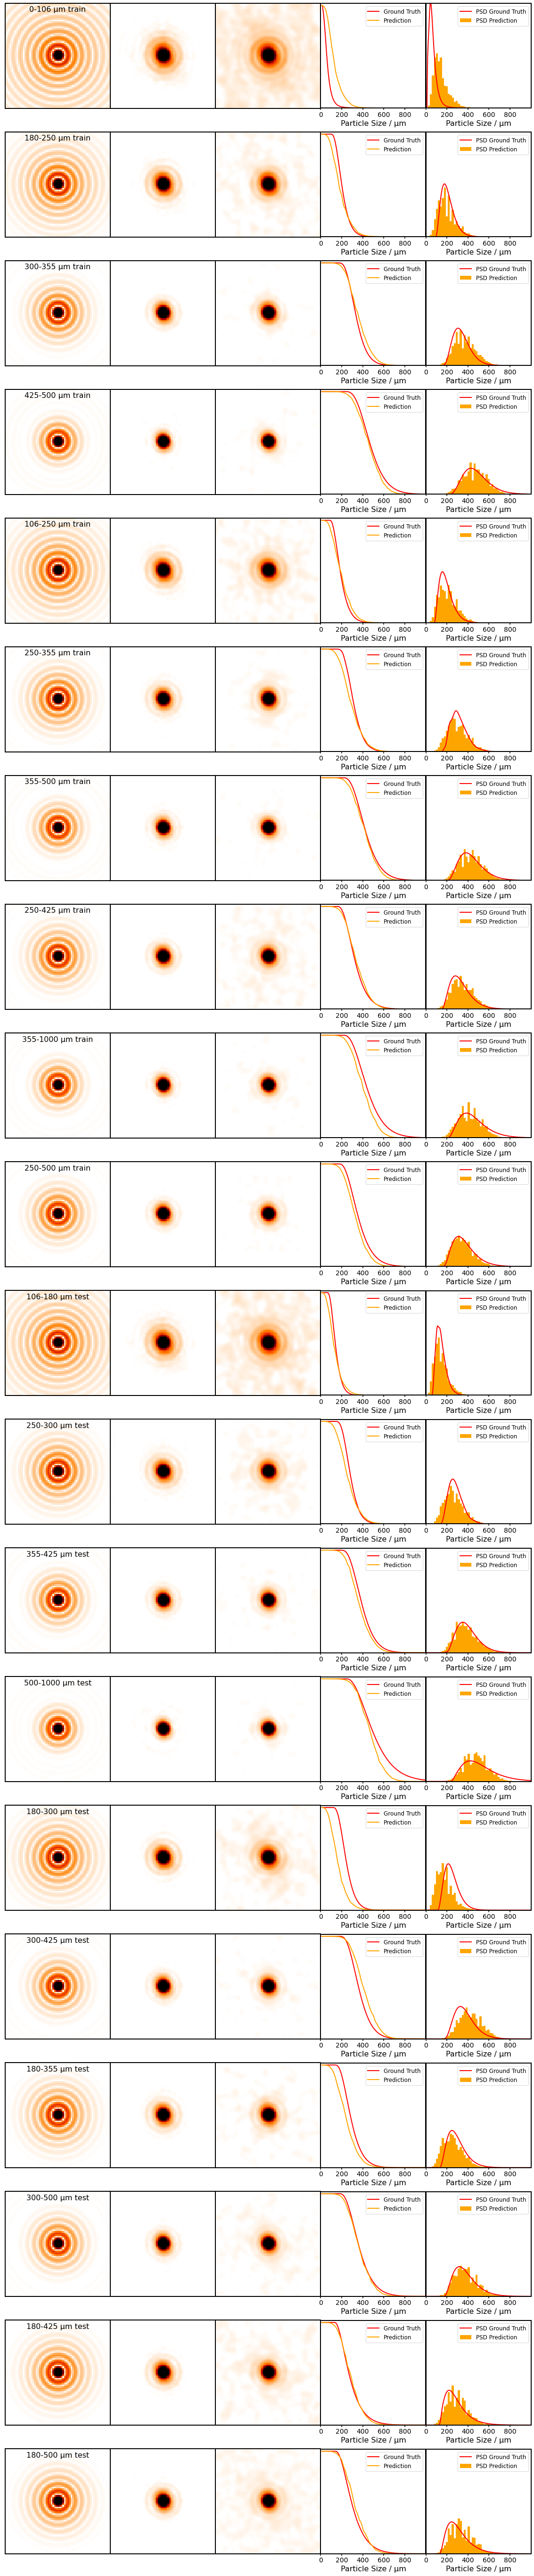

In [12]:

fileidx = 16
auto_expgen_t = torch.tensor(auto_expgen, dtype=torch.float).cuda()
auto_exp_t = torch.tensor(auto_exp, dtype=torch.float).cuda()
cumul_exp_t = torch.tensor(cumul_exp).to('cuda')
auto_predict_expgen_plot = np.zeros((20,64,64))
#average reduce the cumul predict to 64
cumul_predict_plot_r = np.zeros((20,192//3))
cumul_predict_plot = np.zeros((20,192))

pred_PSD = np.zeros((20,cumul_predict_plot_r.shape[-1]-1))
pred_PSD_d = np.zeros((20,cumul_predict_plot.shape[-1]-1))
for i in tqdm(range(20)):
    #predict generalized auto_expgen
    auto_predict_expgen_plot[i] = generator(auto_expgen_t[i,0:1]).reshape((64,64)).cpu().detach().numpy()
    auto_predict_expgen_plot[i] = normalize(auto_predict_expgen_plot[i]) 

    cumul_predict_plot[i] = predictor(auto_exp_t[i,0:1]).reshape(192).cpu().detach().numpy()
    cumul_predict_plot[i] = normalize(cumul_predict_plot[i])#

    cumul_predict_plot_r[i] = rebin1d(cumul_predict_plot[i],(64))
    pred_PSD[i] = -(cumul_predict_plot_r[i] - np.roll(cumul_predict_plot_r[i],1))[1:64]
    pred_PSD[i] = pred_PSD[i]/np.sum(pred_PSD[i])/3
    pred_PSD[i,pred_PSD[i]<0]=0
    
    pred_PSD_d[i] = -(cumul_predict_plot[i] - np.roll(cumul_predict_plot[i],1))[1:192]
    pred_PSD_d[i] = pred_PSD_d[i]/np.sum(pred_PSD_d[i])/3
    pred_PSD_d[i,pred_PSD_d[i]<0]=0
    
    
x_new_r = np.linspace(10, 1200, num=64, endpoint=True)
x_new = np.linspace(10, 1200, num=192, endpoint=True)

    
fig, axs = plt.subplots(20,5, figsize=(4*5, 5*20), facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = 0.1, wspace=.001)
idx = np.array([0,2,4,6,8,10,12,14,16,18,
               1,3,5,7,9,11,13,15,17,19])
for j in range(20):
    i = int(idx[j])
    axs[j,0].pcolormesh((auto_expgen[i,0].reshape((64,64)))**2,vmax=0.5,vmin=0,cmap=plt.cm.gist_heat_r)
    axs[j,0].set_aspect('equal')
    if i%2==0:
        axs[j,0].set_title(name[i] +" train", y=1, pad=-18 ,color='k',fontsize=16)
    elif i%2==1:
        axs[j,0].set_title(name[i]+' test', y=1, pad=-18 ,color='k',fontsize=16)

    axs[j,0].set_xticks([])
    axs[j,0].set_yticks([])
    [x.set_linewidth(2) for x in axs[j,0].spines.values()]
    
    axs[j,1].pcolormesh((auto_predict_expgen_plot[i].reshape((64,64))),vmax=0.5,vmin=0.011,cmap=plt.cm.gist_heat_r)
    axs[j,1].set_aspect('equal')
    axs[j,1].set_yticks([])
    axs[j,1].set_xticks([])
    [x.set_linewidth(2) for x in axs[j,1].spines.values()]

    axs[j,2].pcolormesh((normalize(auto_exp[i,0].reshape((64,64)))),vmax=0.5,vmin=0.016,cmap=plt.cm.gist_heat_r)
    axs[j,2].set_aspect('equal')
    axs[j,2].set_yticks([])
    axs[j,2].set_xticks([])
    [x.set_linewidth(2) for x in axs[j,2].spines.values()]

    axs[j,3].plot(x_new,cumul_exp[i,0],'r-',linewidth=2, label='Ground Truth')
    axs[j,3].plot(x_new_r, cumul_predict_plot_r[i],color='orange',linewidth=2, label='Prediction')
    axs[j,3].legend(prop={'size': 12})
    axs[j,3].set_aspect(995/1.02)
    axs[j,3].set_xlim(0,1000)
    axs[j,3].set_ylim(0.,1.02)
    axs[j,3].set_yticks([])
    axs[j,3].set_xticks([0,200,400,600,800])
    axs[j,3].set_xlabel('Particle Size / μm',fontsize=16)
    axs[j,3].xaxis.set_tick_params(labelsize=14,width=1.5)
    [x.set_linewidth(2) for x in axs[j,3].spines.values()]

    axs[j,4].bar(x_new_r[1:], pred_PSD[i], width=20, fill=True, 
                 color='orange',label='PSD Prediction')
    axs[j,4].plot(x_new, PSD_exp[i,0],color='r',linewidth=2,label='PSD Ground Truth')
    axs[j,4].legend(prop={'size': 12})
    axs[j,4].set_xlim(0,1000)
    axs[j,4].set_ylim(0,0.09)
    axs[j,4].set_yticks([])
    axs[j,4].set_xticks([0,200,400,600,800])
    axs[j,4].xaxis.set_tick_params(labelsize=14,width=1.5)
    axs[j,4].set_xlabel('Particle Size / μm',fontsize=16)
    axs[j,4].set_aspect(995/0.09)
    [x.set_linewidth(2) for x in axs[j,4].spines.values()]



(1, 8, 32, 32)


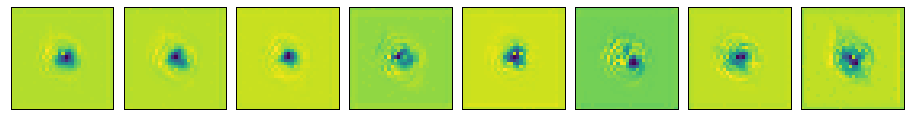

In [13]:
#Plot the output of the first layer
auto_exp_t = torch.tensor(auto_exp, dtype=torch.float).cuda()

testoutput = predictor.first_stage_output((auto_exp_t[0,0:1])).cpu().detach().numpy()
print(testoutput.shape)


fig, axs = plt.subplots(1,8, figsize=(4*4, 5*8), facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = 0.1, wspace=.101005)

for j in range(8):
    axs[j].pcolormesh(testoutput[0,j])
    axs[j].set_aspect('equal')
    axs[j].set_yticks([])
    axs[j].set_xticks([])
    [x.set_linewidth(1) for x in axs[j].spines.values()]


(1, 16, 16, 16)


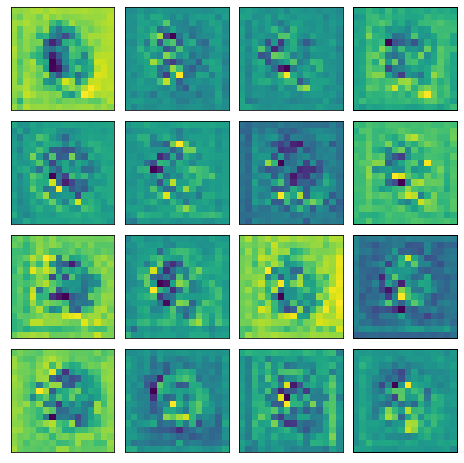

In [14]:
#Plot the output of the second layer
auto_exp_t = torch.tensor(auto_exp, dtype=torch.float).cuda()

testoutput = predictor.second_stage_output((auto_exp_t[0,0:1])).cpu().detach().numpy()
print(testoutput.shape)

fig, axs = plt.subplots(4,4, figsize=(4*2, 2*4.1), facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = 0.1, wspace=.101005)

for i in range(4):
    for j in range(4):
        axs[i,j].pcolormesh(testoutput[0,4*i+j])
        axs[i,j].set_aspect('equal')
        axs[i,j].set_yticks([])
        axs[i,j].set_xticks([])
    [x.set_linewidth(1) for x in axs[i,j].spines.values()]


(1, 32, 8, 8)


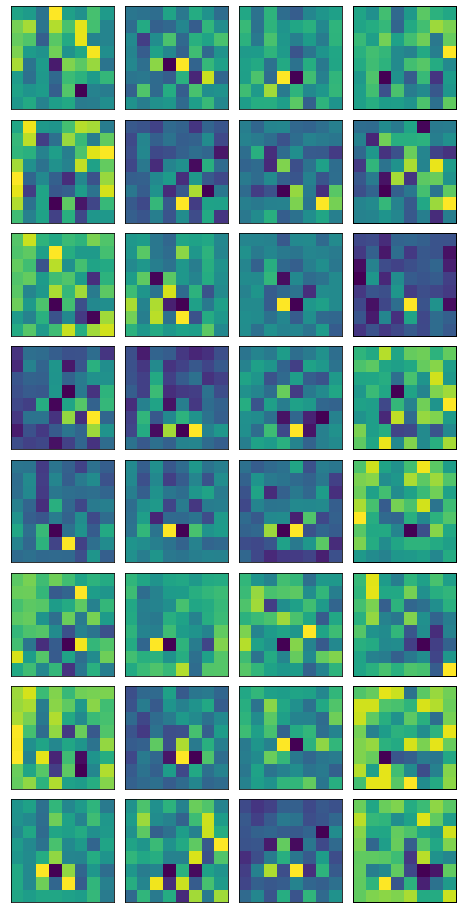

In [15]:
#Plot the output of the third layer
auto_exp_t = torch.tensor(auto_exp, dtype=torch.float).cuda()

testoutput = predictor.third_stage_output((auto_exp_t[0,0:1])).cpu().detach().numpy()
print(testoutput.shape)


fig, axs = plt.subplots(8,4, figsize=(4*2, 2*2*4.12), facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = 0.1, wspace=.10)

for i in range(8):
    for j in range(4):
        axs[i,j].pcolormesh(testoutput[0,4*i+j])
        axs[i,j].set_aspect('equal')
        axs[i,j].set_yticks([])
        axs[i,j].set_xticks([])
    [x.set_linewidth(1) for x in axs[i,j].spines.values()]


(1, 64, 4, 4)


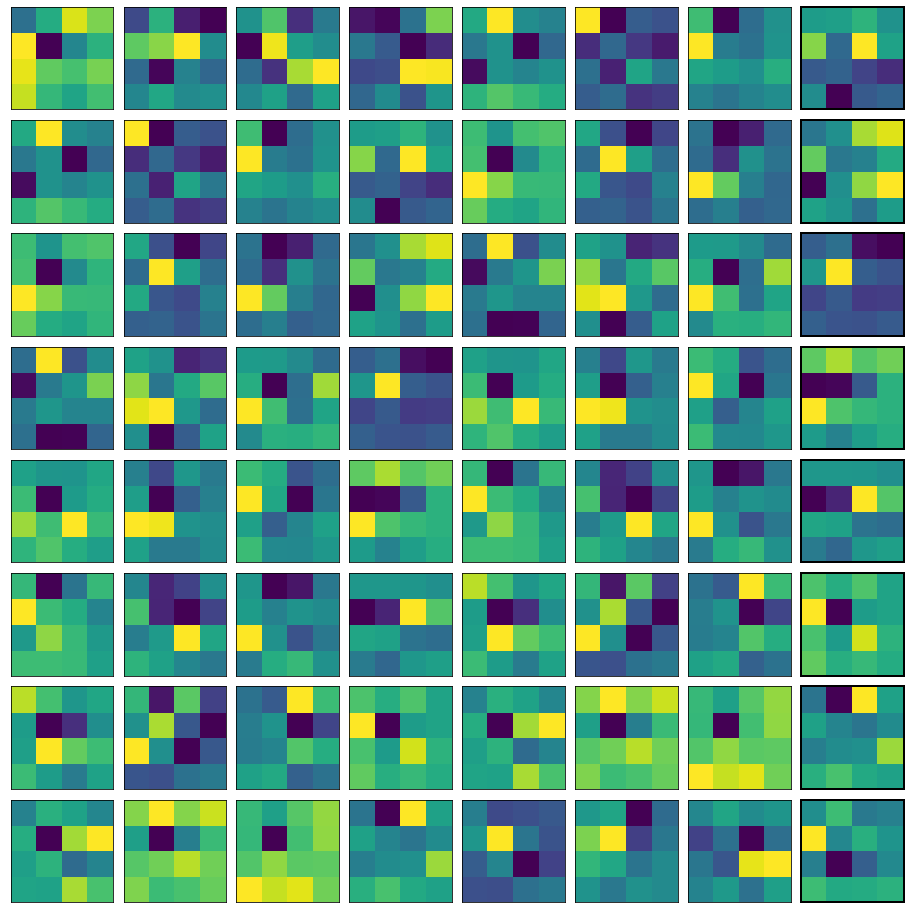

In [16]:
#Plot the output of the fourth layer
auto_exp_t = torch.tensor(auto_exp, dtype=torch.float).cuda()

testoutput = predictor.fourth_stage_output((auto_exp_t[0,0:1])).cpu().detach().numpy()
print(testoutput.shape)


fig, axs = plt.subplots(8,8, figsize=(4*2*2.0, 2*2*4.12), facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = 0.1, wspace=.10)

for i in range(8):
    for j in range(8):
        axs[i,j].pcolormesh(testoutput[0,4*i+j])
        axs[i,j].set_aspect('equal')
        axs[i,j].set_yticks([])
        axs[i,j].set_xticks([])
    [x.set_linewidth(2) for x in axs[i,j].spines.values()]


# GradCAM plot

In [21]:

class GradCamModel(nn.Module):
    def __init__(self,model,target_layer):
        super().__init__()
        self.gradients = None
        self.tensorhook = []
        self.layerhook = []
        self.selected_out = None
        
        #PRETRAINED MODEL
        self.pretrained = model
        self.target_layer = target_layer
        self.layerhook.append(self.target_layer.register_forward_hook(self.forward_hook()))
        
        for p in self.pretrained.parameters():
            p.requires_grad = True
    
    def activations_hook(self,grad):
        self.gradients = grad

    def get_act_grads(self):
        return self.gradients

    def forward_hook(self):
        def hook(module, inp, out):
            self.selected_out = out
            self.tensorhook.append(out.register_hook(self.activations_hook))
        return hook

    def forward(self,x):
        out = self.pretrained(x)
        return out, self.selected_out
    


In [22]:
gcmodel = GradCamModel(predictor, predictor.down_residual_layer_1).to('cuda')


torch.Size([1, 8, 32, 32])
torch.Size([32, 32])
(64, 64)


<ipython-input-25-9442401224fc>:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  [x.set_linewidth(1.5) for x in plt.axes().spines.values()]


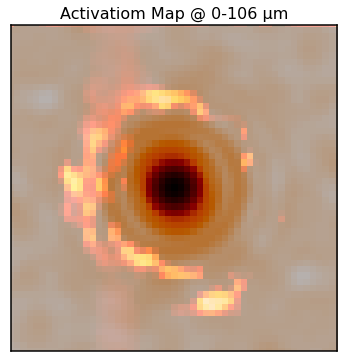

In [25]:
idx=0
out, acts = gcmodel(auto_exp_t[idx,0:1])
acts = acts.detach().cpu()
output_label = torch.tensor(cumul_exp[idx,0:1]).to('cuda')

loss = nn.L1Loss()(out,output_label)
loss.backward()
grads = gcmodel.get_act_grads().detach().cpu()
print(grads.shape)
pooled_grads = torch.mean(grads, dim=[0,2,3]).detach().cpu()

for i in range(acts.shape[1]):
    acts[:,i,:,:] += pooled_grads[i]
heatmap_j = torch.mean(acts, dim = 1).squeeze()
heatmap_j_max = heatmap_j.max(axis = 0)[0]
heatmap_j /= heatmap_j_max
print(heatmap_j.shape)

########################################
from skimage.transform import resize

heatmap_j = resize(heatmap_j,(64,64),preserve_range=True)
print(heatmap_j.shape)
heatmap_j[heatmap_j<-0.2]=-0.2
heatmap_j[heatmap_j>1]=1
heatmap_j = normalize(heatmap_j)


plt.figure(figsize=(6,6))
cmap = plt.cm.get_cmap('hot',256)
heatmap_j2 = cmap(heatmap_j,alpha = 0.3)

auto_gradcam_plot = normalize(ReLU(auto_exp[idx,12,0,:,:]**0.25-0.4))
cmap2 = plt.cm.get_cmap('gist_heat_r',256)
auto_gradcam_plot2 = cmap2(auto_gradcam_plot,alpha = 1)

plt.imshow(auto_gradcam_plot2)
plt.imshow(1*heatmap_j2[:,:],cmap=plt.cm.hsv)#[:,:,0:3])
plt.xlim(6,58)
plt.ylim(6,58)

plt.title('Activatiom Map @ '+ name[idx],fontsize=16)
plt.xticks([])
plt.yticks([])

[x.set_linewidth(1.5) for x in plt.axes().spines.values()]

plt.show()